# German traffic classification using convultion neural network

In [1]:
#some imports along with mxnet
%matplotlib inline
import mxnet as mx
import numpy as np
import cv2
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))



print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print(y_train.shape)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
(39209,)


## Note there are 43 different traffic signs we need to classify

In [4]:
#record the image size, number of channel (RGB) and classes
img_size = X_train[0].shape[0]
num_channels = X_train[0].shape[2]
num_classes = n_classes

In [20]:
## The actual name of classes are given in separate csv file.
## We need to Load the csv file to map from label id to actual name


In [6]:
import csv
def read_csv_and_parse():
    traffic_labels_dict ={}
    with open('signnames.csv') as f:
        reader = csv.reader(f)
        count = -1;
        for row in reader:
            count = count + 1
            if(count == 0):
                continue
            label_index = int(row[0])
            traffic_labels_dict[label_index] = row[1]
    return traffic_labels_dict
traffic_labels_dict = read_csv_and_parse()
print(traffic_labels_dict)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

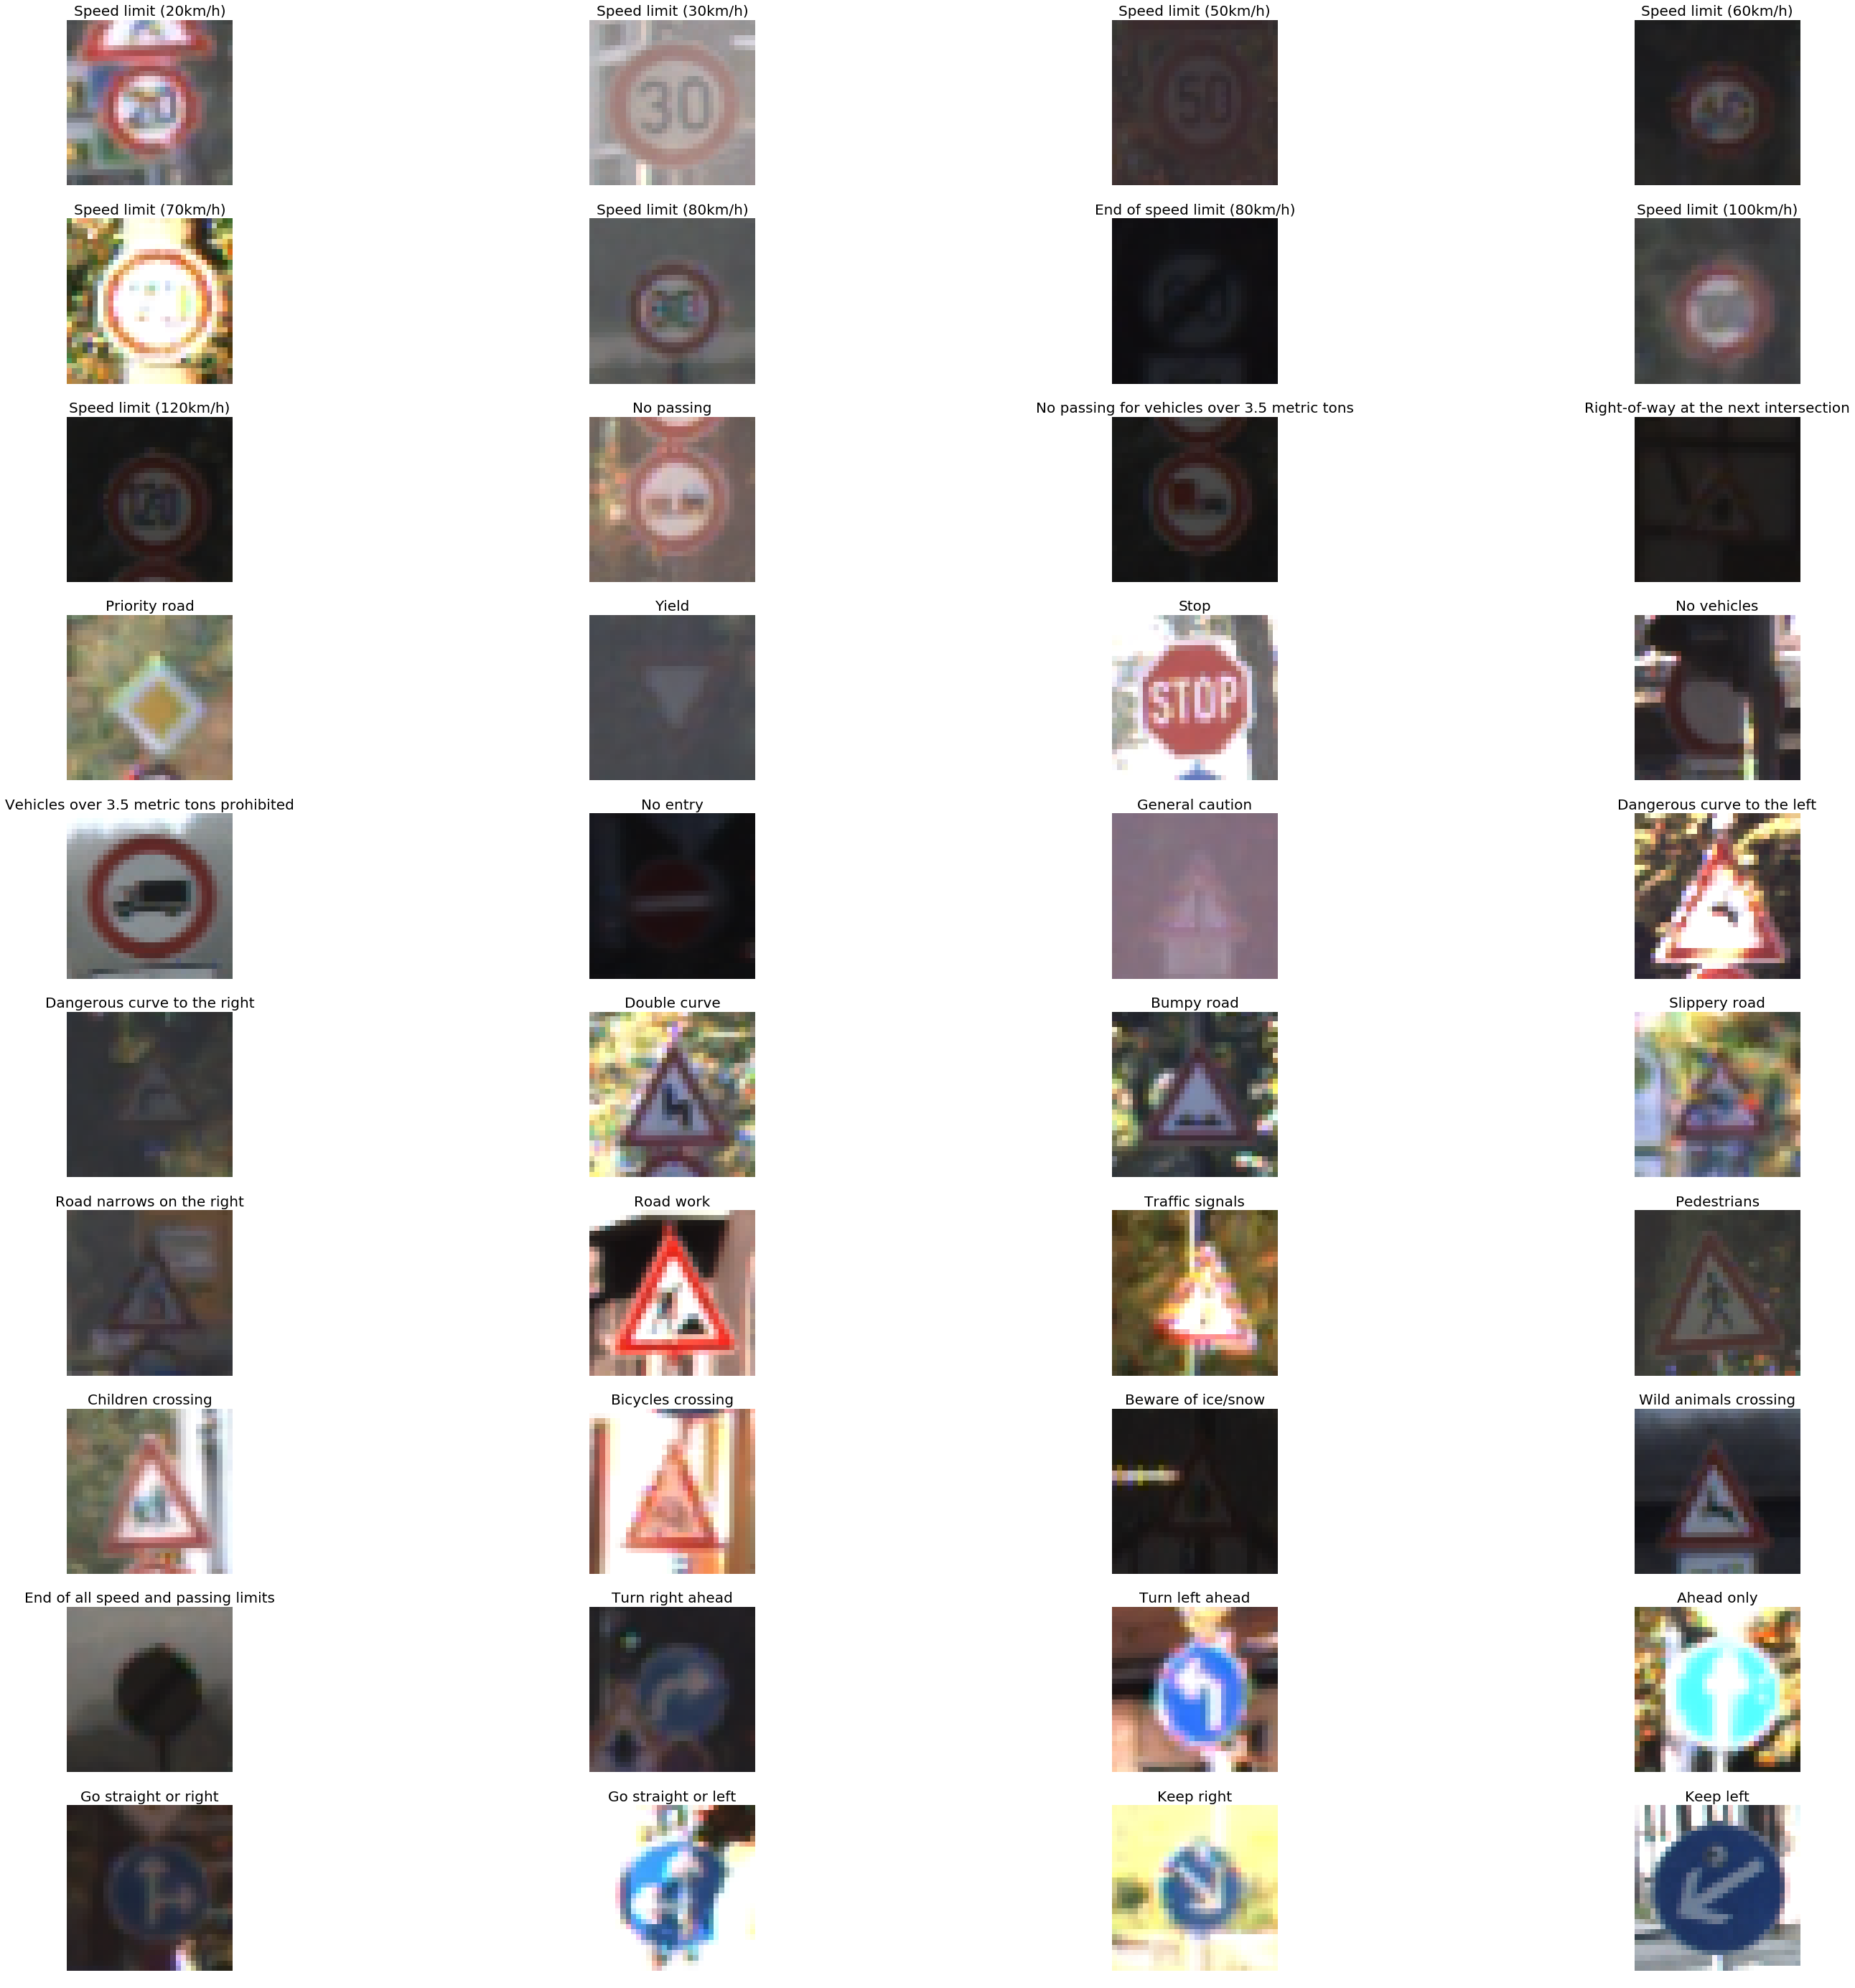

In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
# Visualizations will be shown in the notebook.
%matplotlib inline

def get_images_to_plot(images, labels):
    selected_image = []
    idx = []
    for i in range(n_classes):
        selected = np.where(labels == i)[0][0]
        selected_image.append(images[selected])
        idx.append(selected)
    return selected_image,idx
            
def plot_images(selected_image,row=5,col=10,idx = None):     
    count =0;
    f, axarr = plt.subplots(row, col,figsize=(50, 50))
   
    for i in range(row): 
         for j in range(col):
                if(count < len(selected_image)):
                    axarr[i,j].imshow(selected_image[count])
                    if(idx != None):
                        axarr[i,j].set_title(traffic_labels_dict[y_train[idx[count]]], fontsize=20)
                axarr[i,j].axis('off')
                count = count + 1
           
            

selected_image,idx = get_images_to_plot(X_train,y_train)
plot_images(selected_image,row=10,col=4,idx=idx)

## Above is the plot of various traffic sign along with the corresponding images

In [8]:
def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-Hot encoded class-labels from an array of integers.
    For example, if class_number=2 and num_classes=4 then
    the one-hot encoded label is the float array: [0. 0. 1. 0.]
    :param class_numbers:
        Array of integers with class-numbers.
        Assume the integers are from zero to num_classes-1 inclusive.
    :param num_classes:
        Number of classes. If None then use max(cls)-1.
    :return:
        2-dim array of shape: [len(cls), num_classes]
    """

    # Find the number of classes if None is provided.
    if num_classes is None:
        num_classes = np.max(class_numbers) - 1

    return np.eye(num_classes, dtype=float)[class_numbers]

In [9]:
#count the number of data associated with each label. We can the data is not evenly distributed across the label
print(np.bincount(y_train))


[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]


In [10]:
def get_additional(count, label, X_train, y_train):
    selected = np.where(y_train == label)[0]
    counter = 0;
    m = 0;
    # just select the first element in selected labels
    X_mqp = X_train[selected[0]]
    X_mqp = X_mqp[np.newaxis, ...]
    while m < (len(selected)):
        # ignore the first element, since it already selected
        aa = X_train[selected[m]]
        X_mqp = np.vstack([X_mqp, aa[np.newaxis, ...]])
        if (counter >= count):
            break
        if (m == (len(selected) - 1)):
            m = 0
        counter = counter + 1
        m = m + 1
    Y_mqp = np.full((len(X_mqp)), label, dtype='uint8')

    return X_mqp, Y_mqp

def balance_dataset(X_train_extra, Y_train_extra):
    hist = np.bincount(y_train)
    max_count = np.max(hist)
    for i in range(len(hist)):
        X_mqp, Y_mqp = get_additional(max_count - hist[i], i, X_train, y_train)
        X_train_extra = np.vstack([X_train_extra, X_mqp])
        Y_train_extra = np.append(Y_train_extra, Y_mqp)
    return X_train_extra,Y_train_extra

X_train_extra,Y_train_extra = balance_dataset(X_train,y_train)
print(Y_train_extra.shape)
print(X_train_extra.shape)

(96836,)
(96836, 32, 32, 3)


In [11]:
print(np.bincount(Y_train_extra))
#We can see now the dataset is balanced. The labels are equally distributed

[2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252
 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252
 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252 2252]


In [12]:
#Y_train_hot = one_hot_encoded(Y_train_extra,num_classes)
#Y_test_hot = one_hot_encoded(y_test,num_classes)
Y_train_hot = Y_train_extra
Y_test_hot = y_test

In [13]:
from sklearn.model_selection import train_test_split
X_train_set,X_validation,Y_train_set,Y_validation = train_test_split( X_train_extra, Y_train_hot, test_size=0.02, random_state=42)
print(X_validation.shape)

(1937, 32, 32, 3)


In [55]:
data = mx.symbol.Variable('data')
conv1 = mx.sym.Convolution(data=data, pad=(1,1), kernel=(3,3), num_filter=24, name="conv1")
relu1 = mx.sym.Activation(data=conv1, act_type="relu", name= "relu1")
#pool1 = mx.sym.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool1")
# second conv layer
conv2 = mx.sym.Convolution(data=relu1, kernel=(3,3), num_filter=24, name="conv2", pad=(1,1))
relu2 = mx.sym.Activation(data=conv2, act_type="relu", name="relu2")
pool2 = mx.sym.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool2")
#
#conv3 = mx.sym.Convolution(data=pool2, kernel=(5,5), num_filter=64, name="conv3")
#relu3 = mx.sym.Activation(data=conv3, act_type="relu", name="relu3")
#pool3 = mx.sym.Pooling(data=relu3, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool3")
# first fullc layer
flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500, name="fc1")
relu3 = mx.sym.Activation(data=fc1, act_type="relu" , name="relu3")
# second fullc
fc2 = mx.sym.FullyConnected(data=relu3, num_hidden=43,name="final_fc")
# softmax loss
mynet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

In [56]:
mynet.list_arguments()

['data',
 'conv1_weight',
 'conv1_bias',
 'conv2_weight',
 'conv2_bias',
 'fc1_weight',
 'fc1_bias',
 'final_fc_weight',
 'final_fc_bias',
 'softmax_label']

In [63]:
import mxnet as mx

def to4d(img):
    return img.astype(np.float32)/255

batch_size = 64
X_train_set = X_train_set.astype('float32')
X_train_set[:] = X_train_set[:] / 255.0

Y_validation = Y_train_set.astype('float32')
Y_validation[:] = Y_train_set[:] / 255.0

train_iter =mx.io.NDArrayIter(X_train_set, Y_train_set, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_validation, Y_validation, batch_size)
for batch in train_iter:
    print(batch.data[0].shape)
    break

(64, 32, 32, 3)


In [64]:
adam = mx.optimizer.create('adam', learning_rate=.001)

In [65]:
model = mx.model.FeedForward(
    ctx = mx.gpu(0),     # use GPU 0 for training, others are same as before
    symbol = mynet,       
    num_epoch = 5, 
    optimizer= adam)
model.fit(
    X=train_iter,  
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 64)
) 

INFO:root:Start training with [gpu(0)]
INFO:root:Epoch[0] Batch [64]	Speed: 4444.34 samples/sec	Train-accuracy=0.861572
INFO:root:Epoch[0] Batch [128]	Speed: 4319.70 samples/sec	Train-accuracy=0.923096
INFO:root:Epoch[0] Batch [192]	Speed: 4403.43 samples/sec	Train-accuracy=0.876953
INFO:root:Epoch[0] Batch [256]	Speed: 4399.03 samples/sec	Train-accuracy=0.800049
INFO:root:Epoch[0] Batch [320]	Speed: 4375.07 samples/sec	Train-accuracy=0.861572
INFO:root:Epoch[0] Batch [384]	Speed: 4450.59 samples/sec	Train-accuracy=0.830811
INFO:root:Epoch[0] Batch [448]	Speed: 4405.96 samples/sec	Train-accuracy=0.861572
INFO:root:Epoch[0] Batch [512]	Speed: 4389.94 samples/sec	Train-accuracy=0.923096
INFO:root:Epoch[0] Batch [576]	Speed: 4420.14 samples/sec	Train-accuracy=0.938477
INFO:root:Epoch[0] Batch [640]	Speed: 4362.76 samples/sec	Train-accuracy=0.892334
INFO:root:Epoch[0] Batch [704]	Speed: 4455.96 samples/sec	Train-accuracy=0.923096
INFO:root:Epoch[0] Batch [768]	Speed: 4531.44 samples/sec	Tr

INFO:root:Epoch[4] Batch [128]	Speed: 4424.80 samples/sec	Train-accuracy=0.892334
INFO:root:Epoch[4] Batch [192]	Speed: 4442.79 samples/sec	Train-accuracy=0.969238
INFO:root:Epoch[4] Batch [256]	Speed: 4412.65 samples/sec	Train-accuracy=0.876953
INFO:root:Epoch[4] Batch [320]	Speed: 4494.67 samples/sec	Train-accuracy=0.861572
INFO:root:Epoch[4] Batch [384]	Speed: 4399.18 samples/sec	Train-accuracy=0.923096
INFO:root:Epoch[4] Batch [448]	Speed: 4485.78 samples/sec	Train-accuracy=0.907715
INFO:root:Epoch[4] Batch [512]	Speed: 4528.79 samples/sec	Train-accuracy=0.876953
INFO:root:Epoch[4] Batch [576]	Speed: 4480.92 samples/sec	Train-accuracy=0.830811
INFO:root:Epoch[4] Batch [640]	Speed: 4455.70 samples/sec	Train-accuracy=0.938477
INFO:root:Epoch[4] Batch [704]	Speed: 4457.57 samples/sec	Train-accuracy=0.892334
INFO:root:Epoch[4] Batch [768]	Speed: 4446.05 samples/sec	Train-accuracy=0.892334
INFO:root:Epoch[4] Batch [832]	Speed: 4393.59 samples/sec	Train-accuracy=0.861572
INFO:root:Epoch[